# Feature Selection and Engineering - Beginner's Guide

You all have seen datasets. Sometimes they are small, but often at times, they are tremendously large in size. It becomes very challenging to process the datasets which are very large, at least significant enough to cause a processing bottleneck.

So, what makes these datasets this large? Well, it's features. The more the number of features the larger the datasets will be. Well, not always. You will find datasets where the number of features is very much, but they do not contain that many instances. But that is not the point of discussion here. So, you might wonder with a commodity computer in hand how to process these type of datasets without beating the bush.

Often, in a high dimensional dataset, there remain some entirely irrelevant, insignificant and unimportant features. It has been seen that the contribution of these types of features is often less towards predictive modeling as compared to the critical features. They may have zero contribution as well. These features cause a number of problems which in turn prevents the process of efficient predictive modeling -

- Unnecessary resource allocation for these features.
- These features act as a noise for which the machine learning model can perform terribly poorly.
- The machine model takes more time to get trained.

So, what's the solution here? The most economical solution is Feature Selection.

Feature Selection is the process of selecting out the most significant features from a given dataset. In many of the cases, Feature Selection can enhance the performance of a machine learning model as well.

Sounds interesting right?

You got an informal introduction to Feature Selection and its importance in the world of Data Science and Machine Learning. In this post you are going to cover:

- Introduction to feature selection and understanding its importance
- Difference between feature selection and dimensionality reduction
- Different types of feature selection methods
- Implementation of different feature selection methods with scikit-learn

## A Case study in Python
For this case study, you will use the Pima Indians Diabetes dataset. The description of the dataset can be found [here](https://www.kaggle.com/uciml/pima-indians-diabetes-database). 

The dataset corresponds to classification tasks on which you need to predict if a person has diabetes based on 8 features.

There are a total of `768` observations in the dataset. Your first task is to load the dataset so that you can proceed. But before that let's import the necessary dependencies, you are going to need. You can import the other ones as you go along.

In [1]:
import pandas as pd
import numpy as np

Now that the dependencies are imported let's load the *Pima Indians* dataset into a `Dataframe` object with the help of `Pandas` library.

In [2]:
#data = pd.read_csv("./data/diabetes.csv")
data = pd.read_csv("https://raw.githubusercontent.com/DrJieTao/ba545-docs/master/data/diabetes.csv")

The dataset is successfully loaded into the Dataframe object data. Now, let's take a look at the data.

In [3]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


So you can see 8 different features labeled into the outcomes of `1` and `0` where `1` stands for the observation has diabetes, and `0` denotes the observation does not have diabetes. The dataset is known to have missing values. Specifically, there are missing observations for some columns that are marked as a zero value. You can deduce this by the definition of those columns, and it is impractical to have a zero value is invalid for those measures, e.g., zero for body mass index or blood pressure is invalid.

But for this tutorial, you will directly use the preprocessed version of the dataset.

In [4]:
# load data
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pd.read_csv(url, names=names)

You loaded the data in a DataFrame object called dataframe now.

Let's convert the DataFrame object to a NumPy array to achieve faster computation. Also, let's segregate the data into separate variables so that the features and the labels are separated.

In [5]:
array = dataframe.values
X = array[:,0:8] #features
y = array[:,8] #target

Wonderful! You have prepared your data.

First, you will implement a *Chi-Squared* statistical test for non-negative features to select **4** of the best features from the dataset. You have already seen Chi-Squared test belongs the class of filter methods. If anyone's curious about knowing the internals of Chi-Squared, this [video](https://www.youtube.com/watch?v=VskmMgXmkMQ) does an excellent job.

The `scikit-learn` library provides the `SelectKBest` class that can be used with a suite of different statistical tests to select a specific number of features, in this case, it is Chi-Squared.



In [6]:
# Import the necessary libraries first
#### Correlation method - for classification chi2 only
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#### RFE method - replace the model with the model you plan to use
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
#### feature importance method
#### this method can be used for both topK and cut-off
from sklearn.linear_model import Ridge
#### specifically tree-based feature importance method
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
#### for voting
from collections import Counter
#### for ANOVA
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

### Pearson's R Correlation based
- Used between continuous features

In [7]:
def correlation_feat(df, threshold=0.5):
    """Returns features that are correlated.
    (Set of all the names of correlated columns)
    
    Param:
    ------
    df: Pandas DataFrame
    threshold: float. Default, 0.75
        threshold for the correlation
    """
    feature_corr = {}
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            # absolute coeff value
            if abs(corr_matrix.iloc[i, j]
                   ) > threshold:  
                # getting the name of column
                colname = corr_matrix.columns[i]  
                feature_corr[colname] = round(corr_matrix.iloc[i, j],3)
    return feature_corr

In [8]:
x_df = dataframe.iloc[:,0:8]
correlation_feat(x_df)

{'age': 0.544}

### ANOVA

- Used between continuous and categorical features
- use `f_classif` as the `score_func` in the `SelectKBest()` function

```python
params = {"corr": 0.1, "rfe": 0: ,...}
```

In [9]:
def feature_selector(X, y, model, names, _method="topk", n=int(X.shape[1]/2), fit_X=False, thres = 0.1):
  """voting based feature selector
  - _method: "topk" for top-K method (default), "cutoff" for cut-off based method
  - n: number of features to be selected. only available for top-K method - default half of the total features
  - thres: cut-off threshold (default 0.1), only availabel for cutoff method
  - fit_X: fit_transform X or just return indices
  TODO: include support for regression problems
  """
  #### Placeholder for tests
  # X.shape[0] == y.shape[0]
  if names: # if given feature names
    feature_names = np.array(names)
  else: # otherwise use location
    feature_names = np.array(["X%s" % x for x in range(len(X.shape[0]))])
  if _method == 'topk':
    #### np.argpartition gets the indices of the largest n element from the array in ascending order
    #### [::-1] reverse the order
    ############################################################################
    #### IMPORTANT: 
    #### use `chi2` as the `score_func` when doing categorical features - values has to be non-negative
    #### use `f_classif` as the `score_func` when doing categorical and continuous feautures
    #### use `f_regression` as the `score_func` when doing continuous feautures
    ############################################################################
    corr_features = list(np.argpartition(SelectKBest(score_func=chi2, k=n).fit(X,y).scores_, -n)[-n:][::-1])
    #### binary masking on features, use np.where() to get the indices of selected
    rfe_features = list(np.where(RFE(model, n_features_to_select=n, step=1).fit(X, y).support_)[0])
    #### argsort get sorted indices by values, ::-1] reverse the asceding order
    ridge_features = list(np.argsort(Ridge(alpha=1.0).fit(X, y).coef_)[-n:][::-1])
    #### using ExtraTree
    extratree_features = list(np.argsort(ExtraTreesClassifier().fit(X, y).feature_importances_)[-n:][::-1])
    ### using Random Forest:
    rf_features = list(np.argsort(RandomForestClassifier().fit(X, y).feature_importances_)[-n:][::-1])
    print("Using the Top-K method: ")
    print("Selected features by correlation: ", feature_names[corr_features])
    print("Selected features by RFE: ", feature_names[rfe_features])
    print("Selected features by Ridge coefficients: ", feature_names[ridge_features])
    print("Selected features by Extra Tree feature importance: ", feature_names[extratree_features])
    print("Selected features by Random Forest feature importance: ", feature_names[rf_features])

  elif _method == 'cutoff':
    corr_features, rfe_features = list(), list() #### N/A
    ridge_features = list(np.where(Ridge(alpha=1.0).fit(X, y).coef_ > thres)[0])
    extratree_features = list(np.where(ExtraTreesClassifier().fit(X, y).feature_importances_ > thres)[0])
    rf_features = list(np.where(RandomForestClassifier().fit(X, y).feature_importances_ > thres)[0])
    print("Using the Cutoff method: ")
    # print("Selected features by correlation: ", feature_names[corr_features])
    # print("Selected features by RFE: ", feature_names[rfe_features])
    print("Selected features by Ridge coefficients: ", feature_names[ridge_features])
    print("Selected features by Extra Tree feature importance: ", feature_names[extratree_features])
    print("Selected features by Random Forest feature importance: ", feature_names[rf_features])
  else:
    return("Only Top-K and Cutoff methods are currently supported!")

  ######################################
  #### combine results using voting ####
  ######################################
  counted = Counter(np.concatenate((corr_features, rfe_features, ridge_features, extratree_features, rf_features), axis=None)).most_common(n)

  #### list of tuples (feature_index, votes)
  counted.sort(key = lambda x: x[1], reverse=True)
  final_select_series = pd.Series({feature_names[f]:c for f,c in counted}).sort_values(ascending=False)
  selected_idx = sorted([f for f,c in counted])
  assert len(selected_idx) == n
  print(final_select_series)
  if fit_X:
    return(X[:,selected_idx])
  else:
    return(feature_names[selected_idx])





In [10]:
selected_features = feature_selector(X, y, model=RandomForestClassifier(), names=names, fit_X=True)
selected_features

Using the Top-K method: 
Selected features by correlation:  ['test' 'plas' 'age' 'mass']
Selected features by RFE:  ['plas' 'mass' 'pedi' 'age']
Selected features by Ridge coefficients:  ['pedi' 'preg' 'mass' 'plas']
Selected features by Extra Tree feature importance:  ['plas' 'age' 'mass' 'pedi']
Selected features by Random Forest feature importance:  ['plas' 'mass' 'age' 'pedi']
plas    5
mass    5
age     4
pedi    4
dtype: int64


array([[148.   ,  33.6  ,   0.627,  50.   ],
       [ 85.   ,  26.6  ,   0.351,  31.   ],
       [183.   ,  23.3  ,   0.672,  32.   ],
       ...,
       [121.   ,  26.2  ,   0.245,  30.   ],
       [126.   ,  30.1  ,   0.349,  47.   ],
       [ 93.   ,  30.4  ,   0.315,  23.   ]])

### Feature selection Pipelines
Use this if you want to compare different feature selection strategies (e.g., ANOVA vs. correlation). You can also use this method to get a rough idea of how many features should be selected.

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

In [12]:
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
 cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
 scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
 return scores

selecting 1 features with a bias of 0.435 and a variance of 0.089
selecting 2 features with a bias of 0.421 and a variance of 0.079
selecting 3 features with a bias of 0.398 and a variance of 0.081
selecting 4 features with a bias of 0.400 and a variance of 0.077
selecting 5 features with a bias of 0.383 and a variance of 0.071
selecting 6 features with a bias of 0.393 and a variance of 0.076
selecting 7 features with a bias of 0.382 and a variance of 0.076
selecting 8 features with a bias of 0.380 and a variance of 0.074
best bias of 0.380 with 8 features
best variance of 0.071 with 5 features


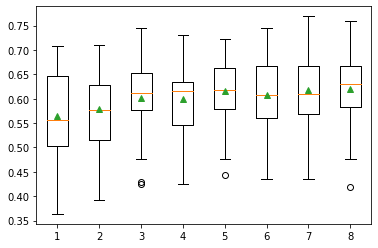

In [13]:
# define number of features to evaluate
num_features = [i+1 for i in range(X.shape[1])]
# enumerate each number of features
results = list()
feat_dict = {}
for k in num_features:
 # create pipeline
 model = LogisticRegression(solver='liblinear')
 fs = SelectKBest(score_func=f_classif, k=k)
 pipeline = Pipeline(steps=[('anova',fs), ('lr', model)])
 # evaluate the model
 scores = evaluate_model(pipeline, X, y)
 results.append(scores)
 feat_dict[k] = (1-np.mean(scores),np.std(scores))
 # summarize the results
 print('selecting {:1d} features with a bias of {:.3f} and a variance of {:.3f}'.format(k, 1-np.mean(scores),np.std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=num_features, showmeans=True);
# pyplot.show()
biases = np.array([v[0] for v in feat_dict.values()])
best_bias = np.argsort(biases)[0]
print("best bias of {:.3f} with {:1d} features".format(biases[best_bias],best_bias+1))
viariances = np.array([v[1] for v in feat_dict.values()])
best_var = np.argsort(viariances)[0]
print("best variance of {:.3f} with {:1d} features".format(viariances[best_var],best_var+1))

In this case, it looks like selecting five and seven features results in roughly the same accuracy. So we can select **5** features.

__NOTE__: We used `f1` as the metric here. You can change it to different metrics to see how the result changes

In [14]:
### if you want the top 3 values for K
k = 3
best_bias = np.argsort(biases)[:k]+1
best_bias
# biases[best_bias]

array([8, 7, 5])

The result shows that the best bias is with all 8 features, then 7 features, then 5. 

You can do something similar for variance.

## NEED MORE HELP?
Refer to [this article](https://towardsdatascience.com/beginners-guide-for-feature-selection-by-a-beginner-cd2158c5c36a) and [this article](https://machinelearningmastery.com/feature-selection-with-numerical-input-data/) if you need more help.